**The script of a movie screening is one of the most impactful reasons why a movie is successful. By analyzing these scripts, we can form a better understanding of what makes a movie successful. Our research and data analysis led us to conclude that specific features and word choices within the script are correlated in different ways, and that can make an impact on the overall success of the movie. These conclusions will be shown in more depth through various graphs.**


In [ ]:
!pip install transformers torch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.7 MB/s eta 0:00:00


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
import torch
from transformers import BertTokenizer, BertModel, pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
import re
import math

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Get worldwide gross revenue (scraped from box office mojo)

In [ ]:
def get_worldwide_gross(movie_name):
    search_url = f'https://www.boxofficemojo.com/search/?q={movie_name.replace(" ", "+")}'
    response = requests.get(search_url)
    soup = BeautifulSoup(response.text, 'html.parser')

    result_link = soup.select_one('a.a-size-medium.a-link-normal.a-text-bold')
    if not result_link:
        return "N/A"

    first_result_title = result_link.text.strip().lower()
    if first_result_title != movie_name.strip().lower():
        return "N/A"

    movie_page_url = 'https://www.boxofficemojo.com' + result_link['href']
    movie_response = requests.get(movie_page_url)
    movie_soup = BeautifulSoup(movie_response.text, 'html.parser')

    money_spans = movie_soup.select('span.a-size-medium.a-text-bold span.money')

    if len(money_spans) >= 3:
        worldwide_gross = money_spans[2].text.strip()
        return worldwide_gross
    else:
        return "N/A"

## Get movie scripts (scraped from IMSDb)

In [ ]:
base_url = "https://imsdb.com"
scripts_url = "https://imsdb.com/all-scripts.html"

response = requests.get(scripts_url)
soup = BeautifulSoup(response.content, 'html.parser')
movies = soup.select('p a')

movies_scripts = []

for movie in movies:
    movie_title = movie.text.strip()
    movie_page_link = base_url + movie.get('href')

    movie_page_response = requests.get(movie_page_link)
    movie_page_soup = BeautifulSoup(movie_page_response.content, 'html.parser')

    rating_tag = movie_page_soup.find('b', string='Average user rating')
    rating_img_tag = rating_tag.find_next('img') if rating_tag else None

    if rating_img_tag:
        rating = rating_img_tag['src'].split('/')[-1].replace('-stars.gif', '')
    else:
        continue

    genre_tag = movie_page_soup.find('b', string='Genres')
    genres = []
    if genre_tag:
        genre_links = genre_tag.find_next_siblings('a', href=True)
        for genre_link in genre_links:
            genres.append(genre_link.text.strip())

    script_link_tag = None
    for link in movie_page_soup.find_all('a', href=True):
        if link.text and 'Read' in link.text and 'Script' in link.text:
            script_link_tag = link
            break

    script_text = ""
    if script_link_tag:
        script_link = base_url + script_link_tag.get('href')
        script_response = requests.get(script_link)
        script_soup = BeautifulSoup(script_response.content, 'html.parser')
        script_pre_tag = script_soup.select_one('td.scrtext pre')
        if script_pre_tag:
            script_text = script_pre_tag.get_text(strip=True)

    gross = get_worldwide_gross(movie_title)

    movies_scripts.append({
        'Title': movie_title,
        'Rating': rating,
        'Genres': genres[:-1],
        'Worldwide Gross': gross,
        'Script': script_text
    })

    time.sleep(.5)

df = pd.DataFrame(movies_scripts).set_index('Title')

## Clean up dataframe and add columns

In [ ]:
df = df[df['Script'] != '']
df = df[df['Worldwide Gross'] != 'N/A']
def count_words(script):
    return len(script.split())
df['Word Count'] = df['Script'].apply(count_words)
def diversity(script):
  script = script.lower()
  unique_words = set(script.split())
  return len(unique_words)/count_words(script)
df['Word Diversity'] = df['Script'].apply(diversity)
df.to_csv('movies.csv')

## Plot word count against rating, plot word diversity against rating

In [ ]:
import plotly.express as px
graph = px.scatter(df, x='Word Count', y='Rating')
correlation = df['Word Count'].corr(df['Rating'])
graph.update_layout(title=f'Correlation: {correlation:.2f}')
graph.show()

graph2 = px.scatter(df, x='Word Diversity', y='Rating')
correlation = df['Word Diversity'].corr(df['Rating'])
graph2.update_layout(title=f'Correlation: {correlation:.2f}')
graph2.show()


From these graphs, we concluded that the word count and word diversity do not have a strong affect on the rating.

## Random Forest Regressor

Process the movie data and apply Random Forest Regressor to predict the worldwide gross of movies based on various features. Then, plot the significance of the different features.


Random Forest R^2 score on training set: 0.8602136810007561
Random Forest R^2 score on test set: -0.2971913007797242


<ipython-input-39-17271d0520b2>:105: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




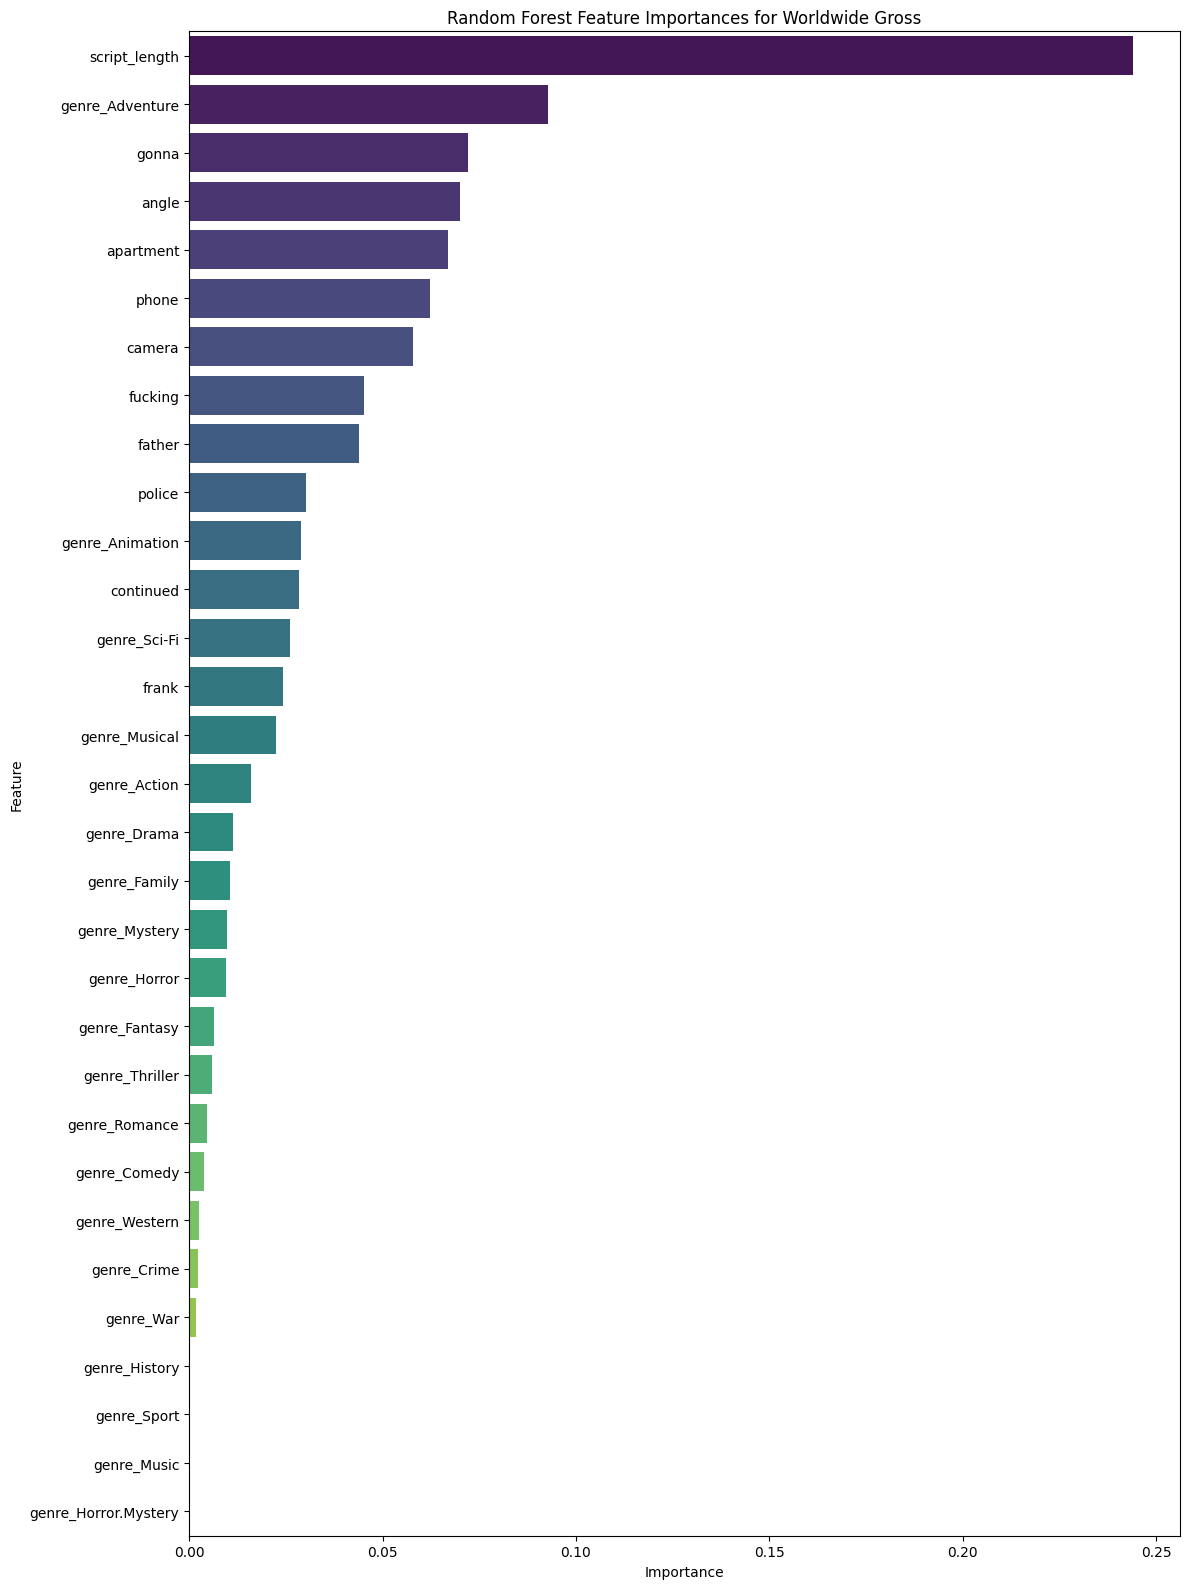

In [ ]:
df = pd.read_csv('movies.csv')

rating_column = 'Rating'
world_gross_column = 'Worldwide Gross'
script_column = 'Script'
genre_column = 'Genres'

df[world_gross_column] = df[world_gross_column].astype(str)
df[world_gross_column] = df[world_gross_column].str.replace('[\$,]', '', regex=True)
df[world_gross_column] = pd.to_numeric(df[world_gross_column], errors='coerce')

def count_words(text):
    tokens = re.findall(r'\b\w+\b', text)
    return len(tokens)

df['script_length'] = df[script_column].fillna("").astype(str).apply(count_words)

#tfidf keywords
tfidf_vectorizer = TfidfVectorizer(
    token_pattern=r'\b[a-zA-Z]{5,}\b',
    stop_words='english',
    max_df=0.85,
    min_df=5,
    max_features=1000
)

scripts = df[script_column].fillna("").astype(str)
tfidf_matrix = tfidf_vectorizer.fit_transform(scripts)
feature_names = tfidf_vectorizer.get_feature_names_out()
#flatten to 1D
avg_tfidf = np.asarray(tfidf_matrix.mean(axis=0)).ravel()
sorted_idx = np.argsort(avg_tfidf)[::-1]
top_terms = feature_names[sorted_idx][:10]

for term in top_terms:
    term_index = tfidf_vectorizer.vocabulary_.get(term)
    df[term] = tfidf_matrix[:, term_index].toarray().ravel()

def parse_genres(x):
    x = str(x).strip()
    if x.startswith("[") and x.endswith("]"):
        x = x[1:-1]
    x = x.replace("'", "").replace('"', "")
    items = []
    for item in x.split(','):
        item = item.strip()
        if item != "":
            items.append(item)
    return items

df[genre_column] = df[genre_column].fillna("[]")
df['genre_list'] = df[genre_column].apply(parse_genres)

all_genres_set = set()
for genres in df['genre_list']:
    for g in genres:
        all_genres_set.add(g)
all_genres = list(all_genres_set)

for genre in all_genres:
    def genre_indicator(x, current_genre):
        if current_genre in x:
            return 1
        else:
            return 0
    dummy_col = []
    for x in df['genre_list']:
        dummy_col.append(genre_indicator(x, genre))
    df["genre_" + genre] = dummy_col

tfidf_feature_cols = []
for term in top_terms:
    tfidf_feature_cols.append(term)

genre_feature_cols = []
for g in all_genres:
    genre_feature_cols.append("genre_" + g)

feature_columns = ['script_length'] + tfidf_feature_cols + genre_feature_cols

df_model = df.dropna(subset=[world_gross_column] + feature_columns).copy()
X = df_model[feature_columns]
y = df_model[world_gross_column]

#Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
r2_train = rf.score(X_train_scaled, y_train)
r2_test = rf.score(X_test_scaled, y_test)
print("\nRandom Forest R^2 score on training set:", r2_train)
print("Random Forest R^2 score on test set:", r2_test)

importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 16))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")
plt.title("Random Forest Feature Importances for Worldwide Gross")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

We concluded that the length of the script has a lot of impact on the revenue, and so does it being in the adventure genre.

## Important features by genre

We felt that it was important to look at the most important features for each genre as well, since it may differ depending on what genre it is.

<ipython-input-37-7d51a7bf0798>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Genre: Mystery -> Train R^2: 0.925, Test R^2: -0.297


<ipython-input-37-7d51a7bf0798>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Genre: Sci-Fi -> Train R^2: 0.874, Test R^2: -4.180


<ipython-input-37-7d51a7bf0798>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Genre: Drama -> Train R^2: 0.842, Test R^2: -0.630


<ipython-input-37-7d51a7bf0798>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Genre: Family -> Train R^2: 0.810, Test R^2: -1.213


<ipython-input-37-7d51a7bf0798>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Genre: Romance -> Train R^2: 0.805, Test R^2: -0.394


<ipython-input-37-7d51a7bf0798>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Genre: Thriller -> Train R^2: 0.852, Test R^2: -0.586


<ipython-input-37-7d51a7bf0798>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Genre: Crime -> Train R^2: 0.826, Test R^2: -0.691


<ipython-input-37-7d51a7bf0798>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Genre: Musical -> Train R^2: 0.791, Test R^2: 0.384


<ipython-input-37-7d51a7bf0798>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Genre: Horror -> Train R^2: 0.824, Test R^2: -0.940


<ipython-input-37-7d51a7bf0798>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Genre: Fantasy -> Train R^2: 0.797, Test R^2: -1.929


<ipython-input-37-7d51a7bf0798>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Genre: Animation -> Train R^2: 0.861, Test R^2: -0.534


<ipython-input-37-7d51a7bf0798>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Genre: Adventure -> Train R^2: 0.866, Test R^2: -0.193


<ipython-input-37-7d51a7bf0798>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Genre: Action -> Train R^2: 0.852, Test R^2: 0.013


<ipython-input-37-7d51a7bf0798>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Genre: Comedy -> Train R^2: 0.895, Test R^2: 0.279


<ipython-input-37-7d51a7bf0798>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Genre: War -> Train R^2: 0.837, Test R^2: -0.390


<ipython-input-37-7d51a7bf0798>:92: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-37-7d51a7bf0798>:92: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-37-7d51a7bf0798>:92: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-37-7d51a7bf0798>:92: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-37-7d51a7bf0798>:92: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and wi

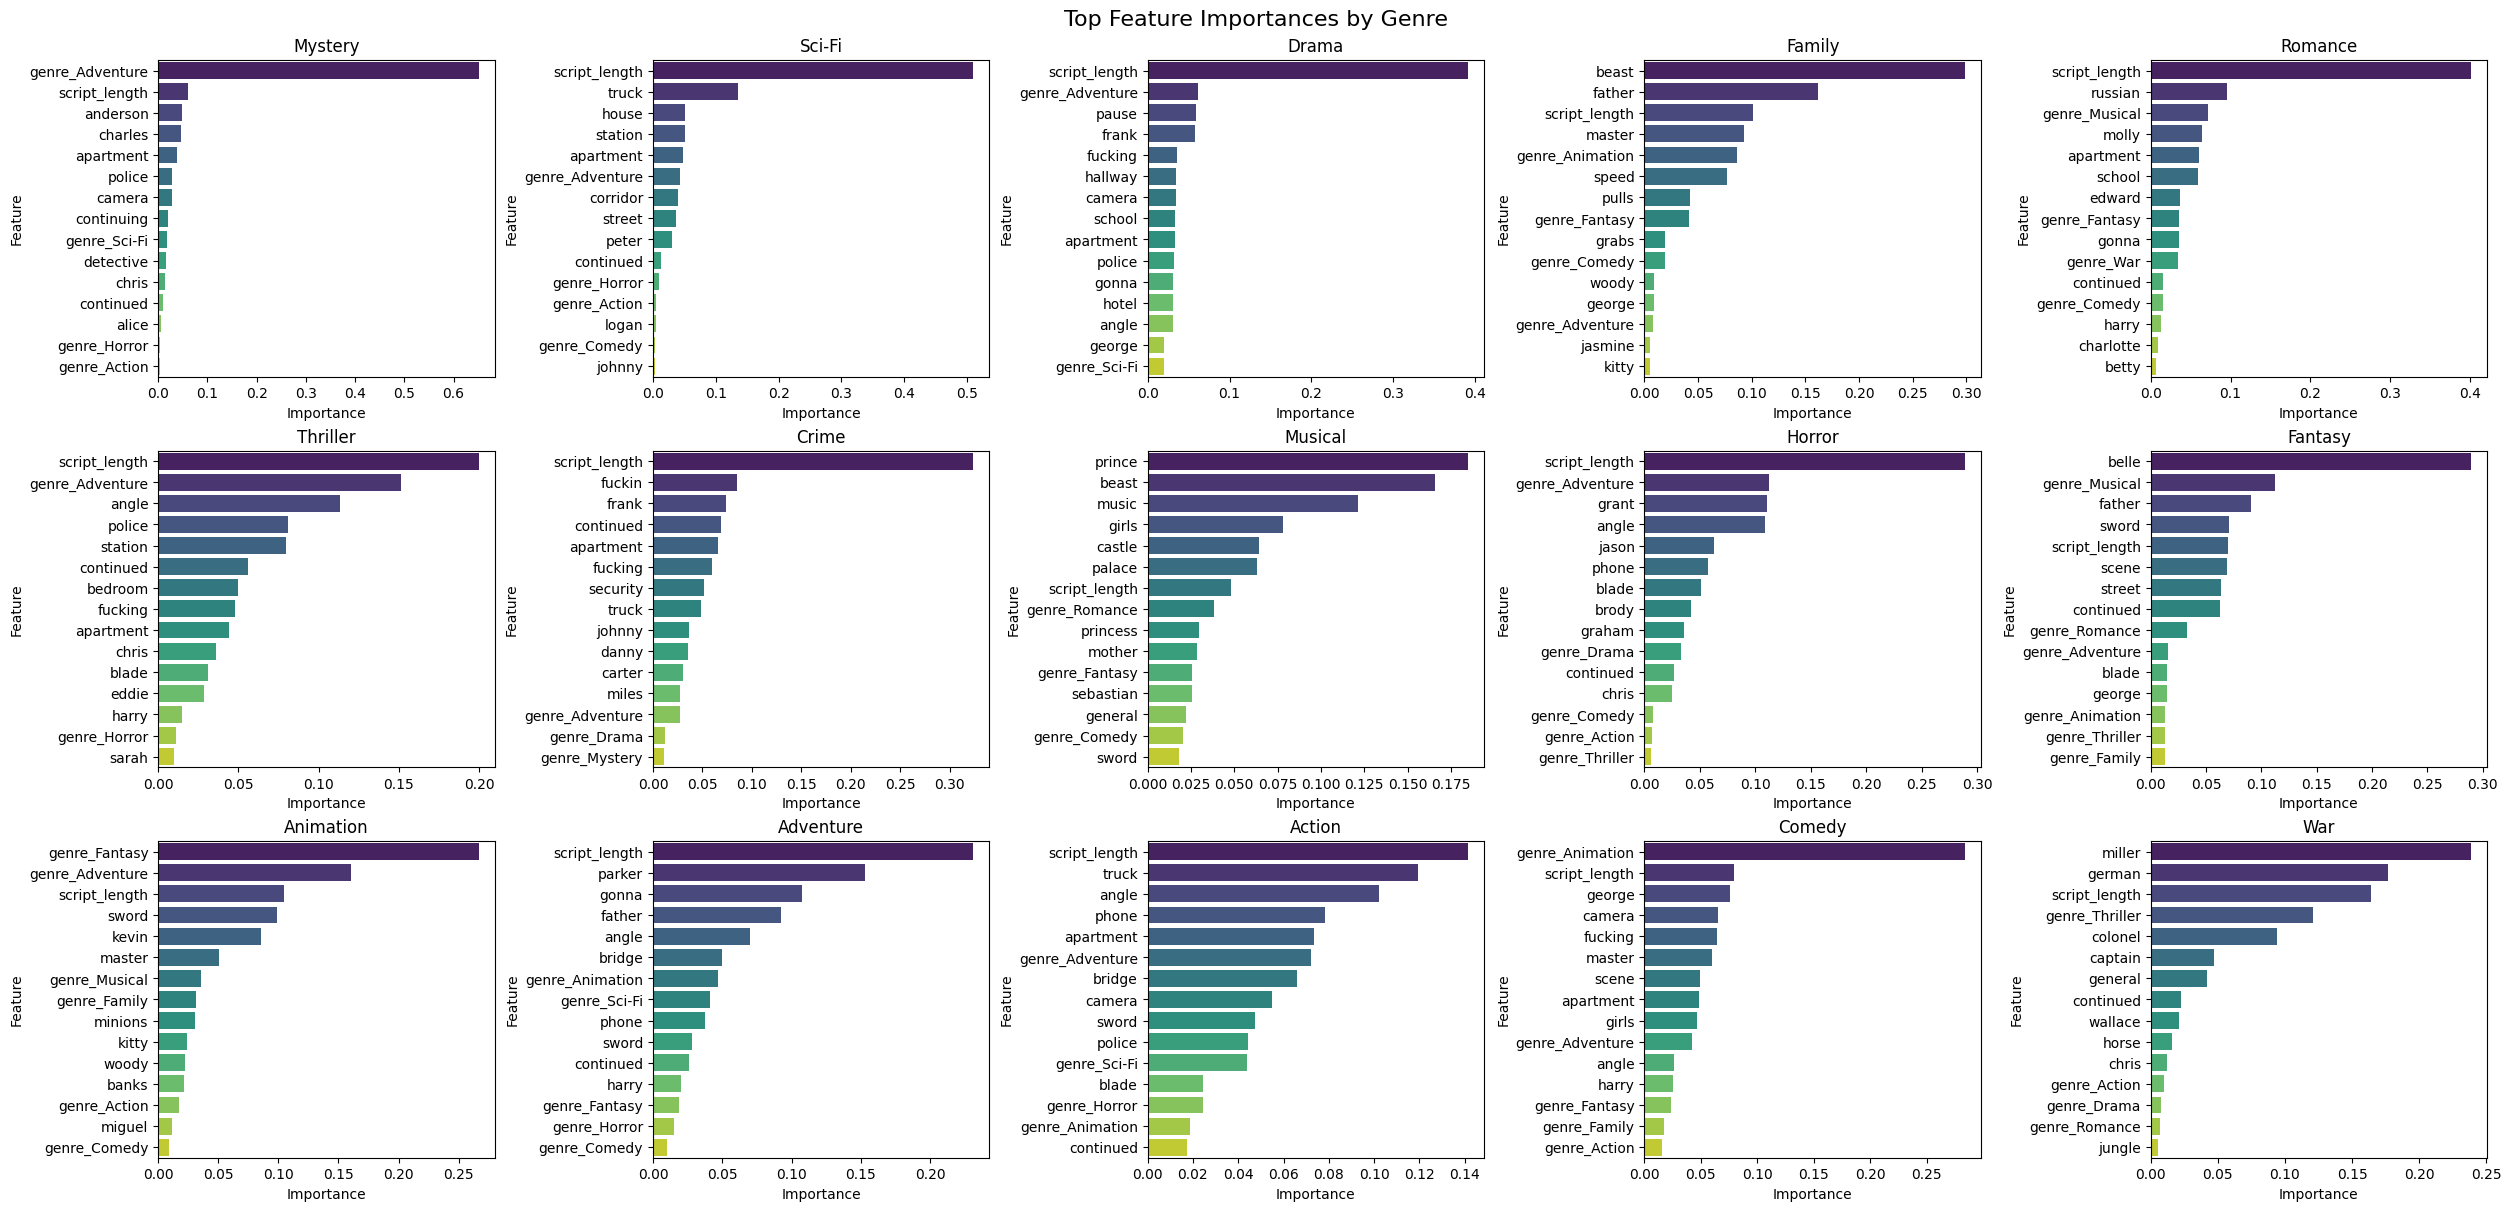

In [ ]:
TOP_N_FEATURES = 15   # How many top features to show per genre
TOP_N_WORDS = 15      # How many top words to select per genre
N_ROWS = 5            # Number of subplots per row in the grid

genre_fi_dict = {}

def genre_in_list(x, g):
    return g in x

for genre in all_genres:
    subset_df = df_model[df_model['genre_list'].apply(genre_in_list, args=(genre,))]
    n_samples = len(subset_df)

    # Skip genres with too few samples
    if n_samples < 10:
        continue

    # Run TF-IDF on the scripts
    scripts_subset = subset_df[script_column].fillna("").astype(str)
    tfidf_vectorizer_subset = TfidfVectorizer(
         token_pattern=r'\b[a-zA-Z]{5,}\b',
         stop_words='english', #removes common english words that have little semantic meaning (the, is, and)
         max_df=0.85,
         min_df=2,
         max_features=1000
    )
    tfidf_matrix_subset = tfidf_vectorizer_subset.fit_transform(scripts_subset)

    # Get feature names and average TF-IDF scores, then select the top words
    feature_names_subset = tfidf_vectorizer_subset.get_feature_names_out()
    avg_tfidf_subset = tfidf_matrix_subset.mean(axis=0).A1
    sorted_idx_subset = avg_tfidf_subset.argsort()[::-1]
    top_words = feature_names_subset[sorted_idx_subset][:TOP_N_WORDS]

    tfidf_df = pd.DataFrame(
         tfidf_matrix_subset.toarray(),
         columns=tfidf_vectorizer_subset.get_feature_names_out(),
         index=subset_df.index
    )

    tfidf_features = tfidf_df[top_words]

    # Include script length as a feature
    tfidf_features['script_length'] = subset_df['script_length']

    new_tfidf_cols = []
    new_tfidf_cols.append('script_length')
    for word in top_words:
        new_tfidf_cols.append(word)

    dummy_feature_cols = []
    for g in all_genres:
        dummy_feature_cols.append(f"genre_{g}")
    dummy_features = subset_df[dummy_feature_cols]
    X_genre = pd.concat([tfidf_features[new_tfidf_cols], dummy_features], axis=1)
    y_genre = subset_df[world_gross_col]

    final_feature_columns = new_tfidf_cols + dummy_feature_cols

    # Split and scale the data
    X_train, X_test, y_train, y_test = train_test_split(
         X_genre, y_genre, test_size=0.2, random_state=42
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # Model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)

    r2_train = rf.score(X_train_scaled, y_train)
    r2_test  = rf.score(X_test_scaled, y_test)

    importances = rf.feature_importances_
    fi_df = pd.DataFrame({
         'Feature': final_feature_columns,
         'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(TOP_N_FEATURES)

    genre_fi_dict[genre] = fi_df

num_plots = len(genre_fi_dict)
nrows = math.ceil(num_plots / N_ROWS)
fig, axes = plt.subplots(nrows, N_ROWS, figsize=(N_ROWS*5, nrows*4), constrained_layout=True)
axes = axes.flatten()  # flatten for easy iteration

# Plot each genre's feature importance on its respective subplot
for i, (genre, fi_df) in enumerate(genre_fi_dict.items()):
      ax = axes[i]
      sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis', orient='h', ax=ax)
      ax.set_title(f"{genre}")
      ax.set_xlabel("Importance")
      ax.set_ylabel("Feature")

    # Turn off any unused subplots
for j in range(i+1, len(axes)):
      axes[j].axis('off')

fig.suptitle("Top Feature Importances by Genre", fontsize=16)
plt.show()

We can see that some genres are more closely interlinked, and so are certain terms. For example, in musical, the terms prince, beast, music, etc. are important for being a successful movie.

## BERT

This was done to see the relationships between certain features and word choices. A heatmap was produced, showing these different relationships.

Device set to use cpu


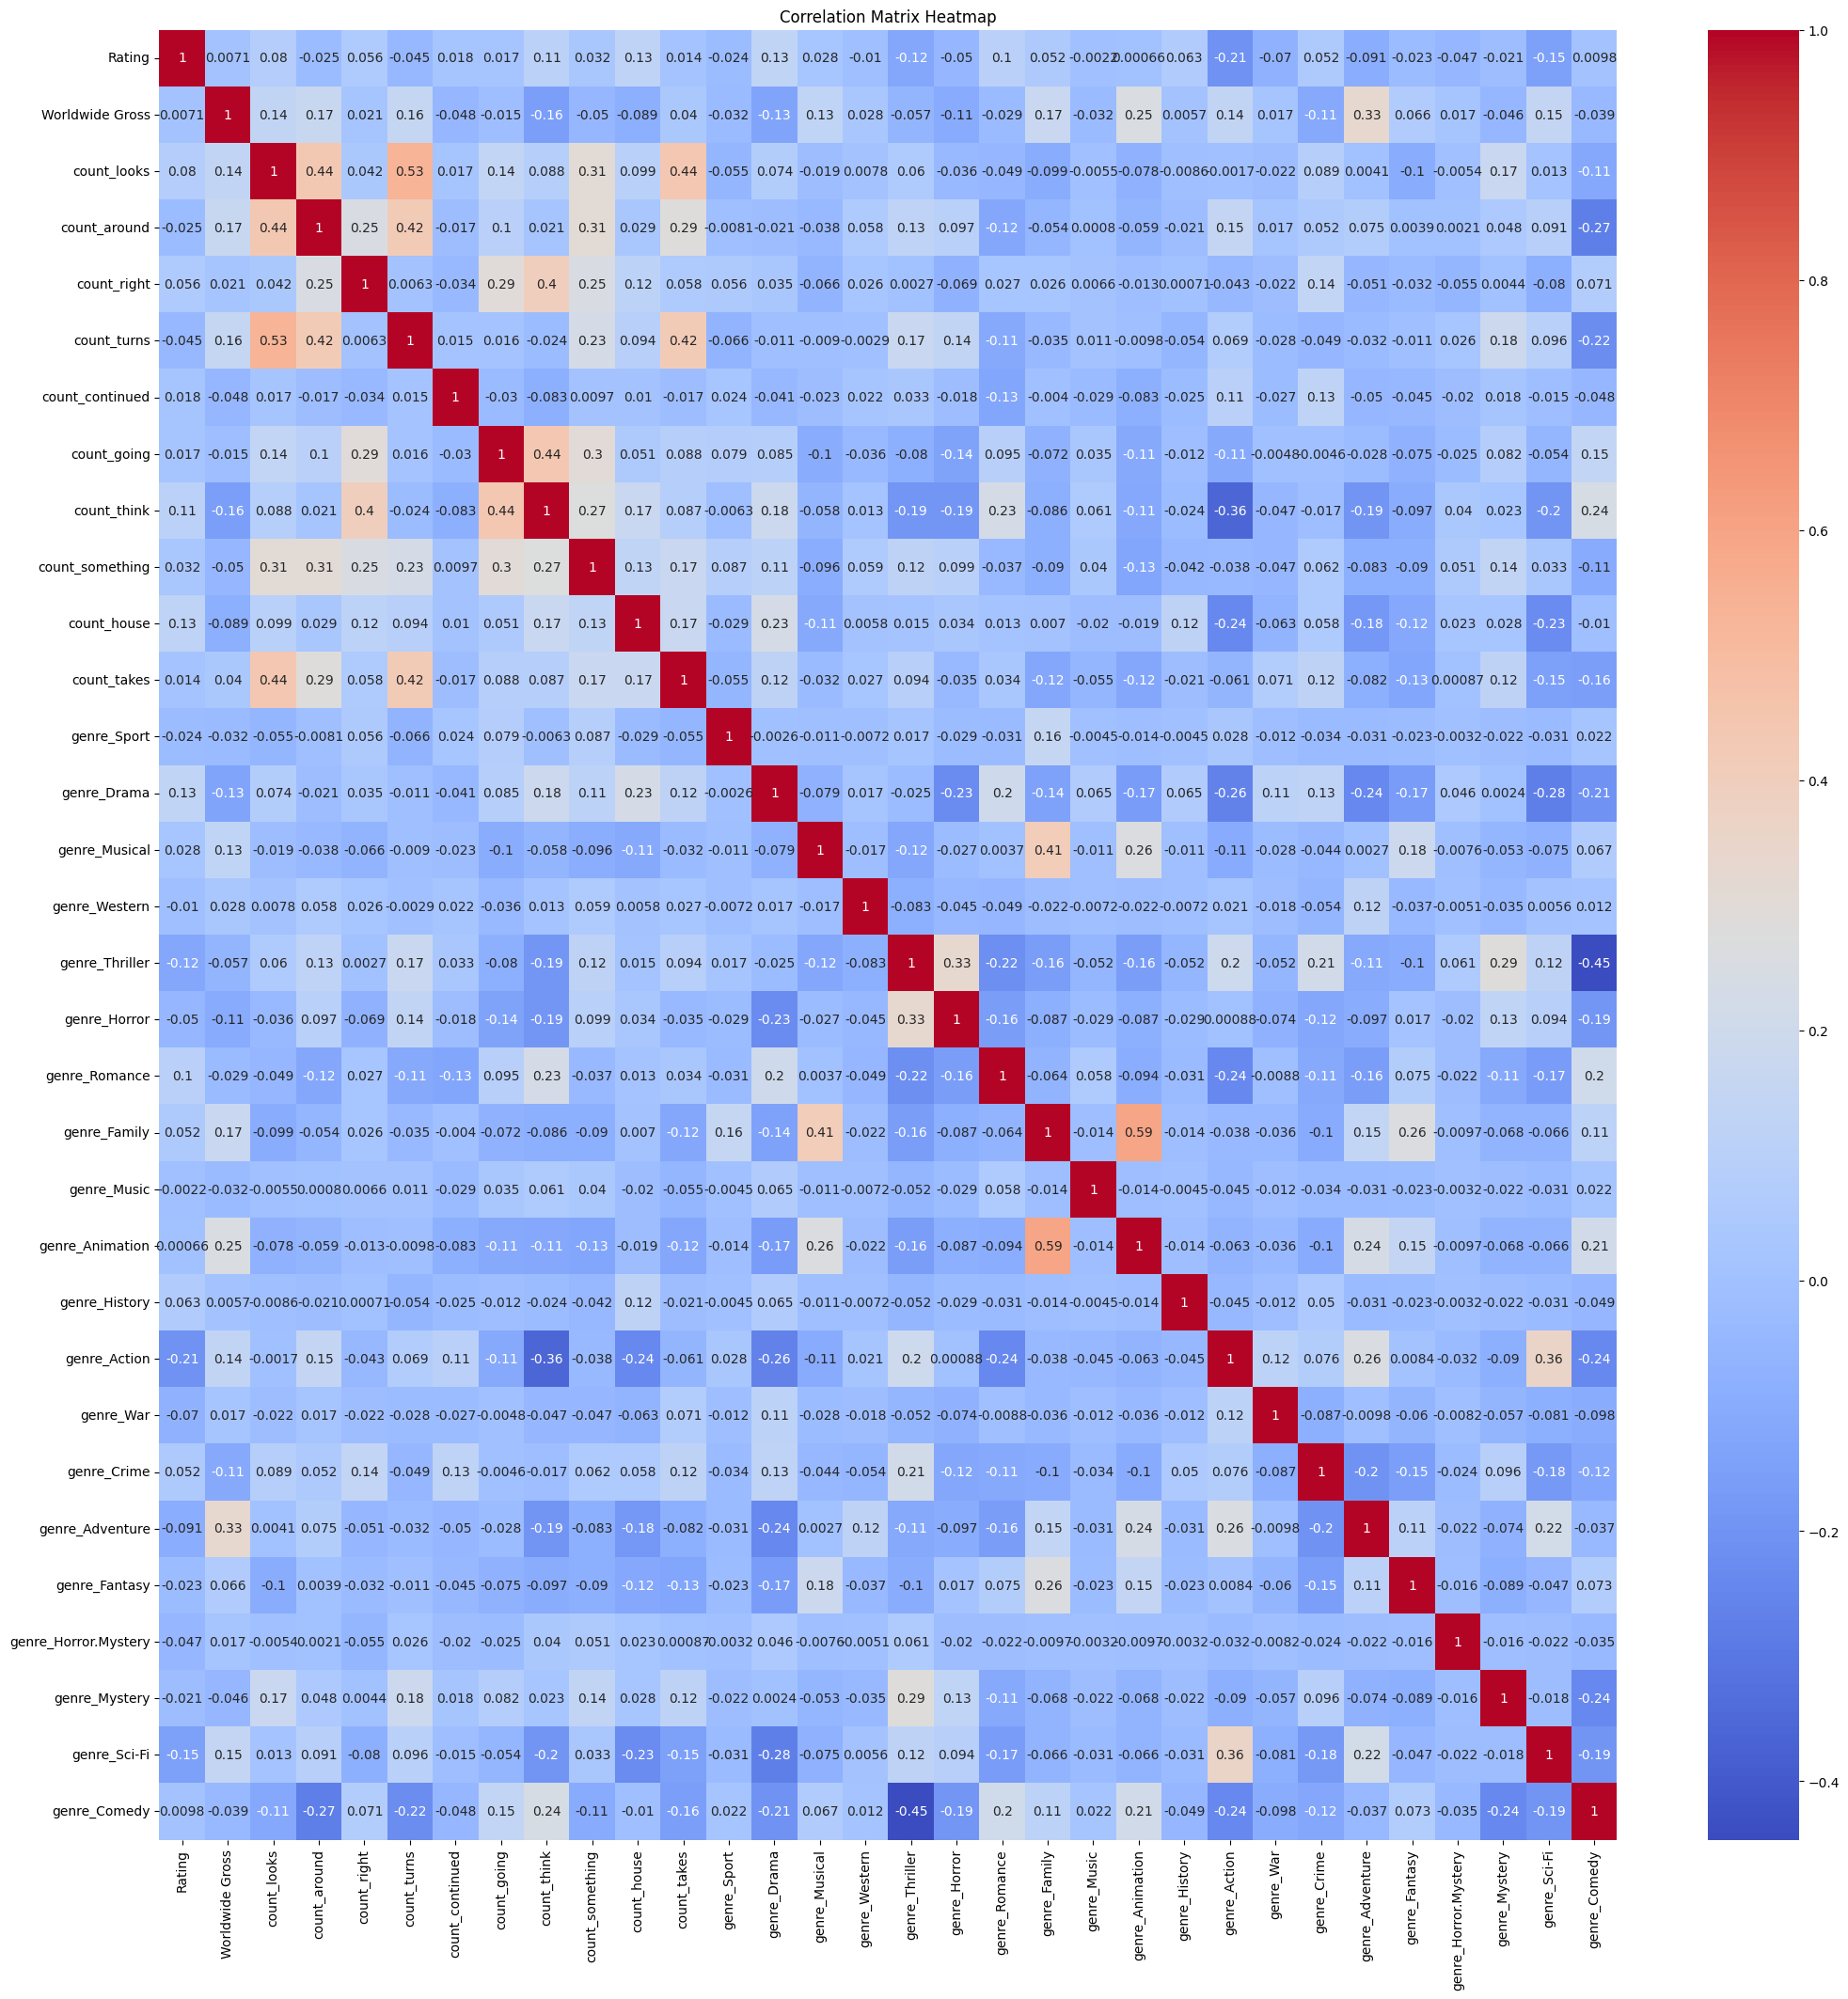

In [ ]:
df = pd.read_csv('movies.csv')

rating_column = 'Rating'
world_gross_column = 'Worldwide Gross'
script_column = 'Script'
genre_column = 'Genres'

df[world_gross_column] = df[world_gross_column].astype(str)
df[world_gross_column] = df[world_gross_column].str.replace('[\$,]', '', regex=True)
df[world_gross_column] = pd.to_numeric(df[world_gross_column], errors='coerce')

def count_words(text):
    tokens = re.findall(r'\b\w+\b', text)
    return len(tokens)

df['script_length'] = df[script_column].fillna("").astype(str).apply(count_words)

MIN_WORD_LENGTH = 5
def tokenize(text):
    tokens = re.findall(r'\b[a-zA-Z]+\b', text.lower())
    tokens = [t for t in tokens if len(t) >= MIN_WORD_LENGTH]
    return tokens

stop_words = set(stopwords.words('english'))
all_tokens = []
for script in df[script_column].fillna("").astype(str):
    tokens = tokenize(script)
    tokens = [t for t in tokens if t not in stop_words]
    all_tokens.extend(tokens)

top_n = 10
counter = Counter(all_tokens)
most_common_words = [word for (word, _) in counter.most_common(top_n)]

for word in most_common_words:
    df["count_" + word] = 0

def count_top_words(text):
    tokens = tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    token_count = Counter(tokens)
    counts = []
    for word in most_common_words:
        counts.append(token_count[word])
    return counts

for idx, script in df[script_column].fillna("").astype(str).items():
    counts = count_top_words(script)
    for i in range(len(most_common_words)):
        df.at[idx, "count_" + most_common_words[i]] = counts[i]

def parse_genres(x):
    x = str(x).strip()
    if x.startswith("[") and x.endswith("]"):
        x = x[1:-1]
    x = x.replace("'", "").replace('"', "")
    items = []
    for item in x.split(','):
        item = item.strip()
        if item != "":
            items.append(item)
    return items

df[genre_column] = df[genre_column].fillna("[]")
df['genre_list'] = df[genre_column].apply(parse_genres)

all_genres_set = set()
for genres in df['genre_list']:
    for g in genres:
        all_genres_set.add(g)
all_genres = list(all_genres_set)

for genre in all_genres:
    dummy_list = []
    for x in df['genre_list']:
        if genre in x:
            dummy_list.append(1)
        else:
            dummy_list.append(0)
    df["genre_" + genre] = dummy_list

feature_extractor = pipeline("feature-extraction", model="bert-base-uncased")

def get_bert_embedding(text):
    outputs = feature_extractor(text, truncation=True, max_length=128)
    embedding = np.mean(outputs[0], axis=0)
    return embedding

df['script_embedding'] = df[script_column].fillna("").astype(str).apply(get_bert_embedding)
df['genre_embedding']  = df[genre_column].fillna("").astype(str).apply(get_bert_embedding)
df['combined_embedding'] = df.apply(lambda row: (row['script_embedding'] + row['genre_embedding']) / 2.0, axis=1)

genre_dummy_cols = []
for g in all_genres:
    genre_dummy_cols.append("genre_" + g)
count_word_cols = []
for w in most_common_words:
    count_word_cols.append("count_" + w)
correlation_cols = [rating_column, world_gross_column] + count_word_cols + genre_dummy_cols

df_corr = df[correlation_cols].apply(pd.to_numeric, errors='coerce')
df_corr = df_corr.dropna()

corr_matrix = df_corr.corr()

plt.figure(figsize=(25, 25))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm",
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)
plt.title("Correlation Matrix Heatmap")
plt.xticks(rotation=90)
plt.show()

From this heatmap, various correlations can be seen. For example, family and animation are more closely correlated, which shows that these can work together to produce a successful movie.

## Sentiment Analysis

We wanted to look at the sentiments of movies as well, to see if that gave us any insightful indications.

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Correlation between sentiment and worldwide gross:
                 sentiment  Worldwide Gross
sentiment         1.000000         0.057586
Worldwide Gross   0.057586         1.000000

Correlation between sentiment and rating:
           sentiment    Rating
sentiment   1.000000  0.115753
Rating      0.115753  1.000000


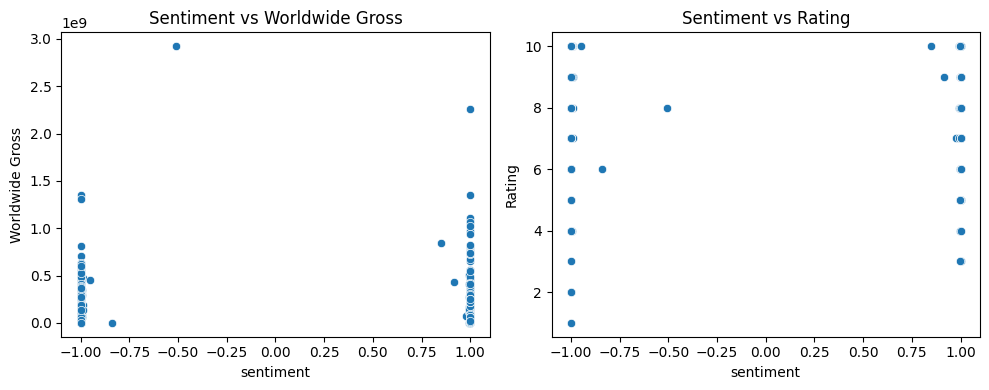

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

df = pd.read_csv('movies.csv')

script_column = 'Script'
world_gross_column = 'Worldwide Gross'
rating_column = 'Rating'

df[world_gross_column] = df[world_gross_column].astype(str).str.replace('[\$,]', '', regex=True)
df[world_gross_column] = pd.to_numeric(df[world_gross_column], errors='coerce')

sia = SentimentIntensityAnalyzer()

def compute_compound(text):
    scores = sia.polarity_scores(text)
    return scores['compound']

df['sentiment'] = df[script_column].fillna("").apply(compute_compound)

corr_sentiment_revenue = df[['sentiment', world_gross_column]].corr()
corr_sentiment_rating = df[['sentiment', rating_column]].corr()

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='sentiment', y=world_gross_column)
plt.title("Sentiment vs Worldwide Gross")

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='sentiment', y=rating_column)
plt.title("Sentiment vs Rating")

plt.tight_layout()
plt.show()

We concluded from these graphs that sentiment usually was on one side or another, and that this did not have a significant effect on gross or rating.

## Topic Modeling

Topic modeling was done to uncover any thematic structures or themes in these scripts. We did not include this in the poster because we felt that other models demanded more attention and gave more significant results for our topic.

Data preview:
                        Title  Rating                           Genres  \
0  10 Things I Hate About You       9            ['Comedy', 'Romance']   
1              12 and Holding       7                        ['Drama']   
2                  12 Monkeys       9  ['Drama', 'Sci-Fi', 'Thriller']   
3                  15 Minutes       7  ['Action', 'Crime', 'Thriller']   
4                    17 Again       8   ['Comedy', 'Drama', 'Romance']   

  Worldwide Gross                                             Script  \
0     $53,683,812  Ten Things I Hate About You - by Karen McCulla...   
1        $119,195  12 AND HOLDINGWritten byAnthony S Cipriano04.0...   
2    $168,839,459  Twelve MonkeysTWELVE MONKEYSAn original screen...   
3     $56,359,980  15 MinutesFADE INon the words CZECH AIRLINE.  ...   
4    $136,316,880  17 AGAINWritten byJason FilardiOctober 2007EXT...   

   Word Count  Word Diversity  
0       15761        0.326756  
1       15837        0.287049  
2       2875

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.




Topics discovered with NMF:
Topic 0: dont know im like get back one looks see got
Topic 1: sam sams george lucy ali robin molly suzy mae kelly
Topic 2: back int looks one continued ext door like around see
Topic 3: chris neil barnes jill ashley back cont carrie get spider
Topic 4: nick nicks jack clyde judy beat godzilla audrey looks adam


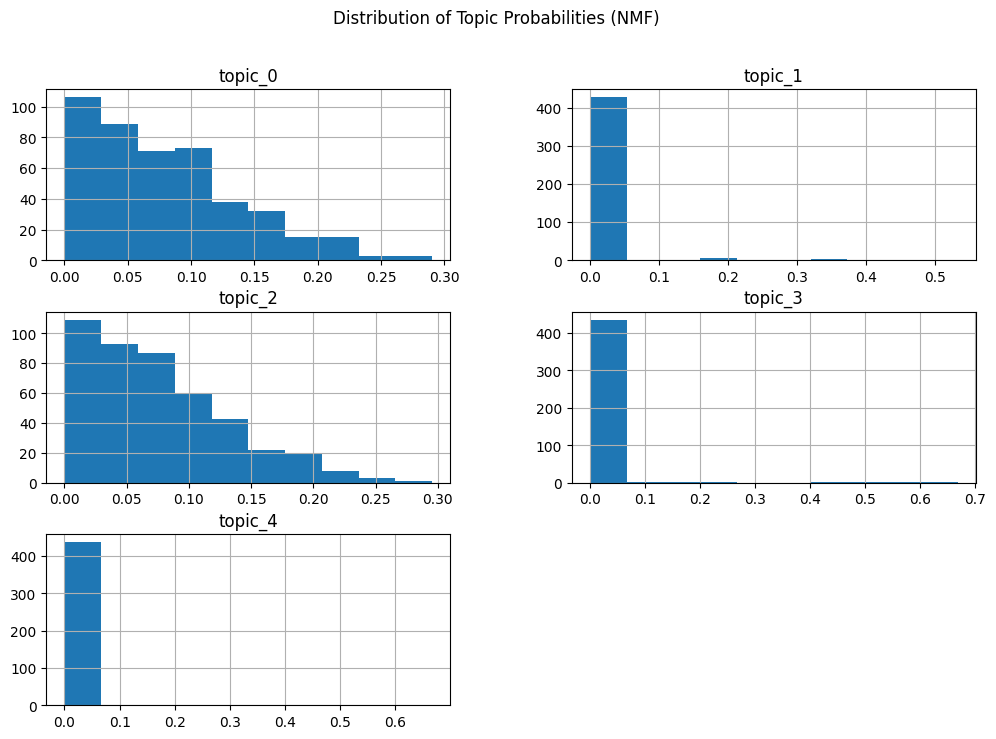

In [ ]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv('movies.csv')

script_column = 'Script'

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

df['clean_script'] = df[script_column].fillna("").apply(preprocess_text)

stop_words = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=5, token_pattern=r'\b[a-zA-Z]+\b')
tfidf_matrix = vectorizer.fit_transform(df['clean_script'])
feature_names = vectorizer.get_feature_names_out()

n_topics = 5
nmf_model = NMF(n_components=n_topics, random_state=42)
nmf_model.fit(tfidf_matrix)

def display_topics(model, feature_names, no_top_words):
    topics_list = []
    for topic_idx, topic in enumerate(model.components_):
        # Get the indices for the top words in this topic
        top_indices = topic.argsort()[::-1][:no_top_words]
        top_words = []
        for idx in top_indices:
            top_words.append(feature_names[idx])
        topics_list.append(top_words)
    return topics_list

topics = display_topics(nmf_model, feature_names, 10)
print("\nTopics discovered with NMF:")
i = 0
for topic in topics:
    # Print each topic's top words, separated by spaces.
    topic_str = ""
    for word in topic:
        topic_str += word + " "
    print(f"Topic {i}: {topic_str.strip()}")
    i += 1

doc_topic_distr = nmf_model.transform(tfidf_matrix)
for topic_idx in range(n_topics):
    col_name = "topic_" + str(topic_idx)
    df[col_name] = doc_topic_distr[:, topic_idx]

topic_cols = []
for i in range(n_topics):
    topic_cols.append("topic_" + str(i))
df[topic_cols].hist(figsize=(12, 8))
plt.suptitle("Distribution of Topic Probabilities (NMF)")
plt.show()

**CONCLUSIONS:
We found that word count and diversity contribute to revenue but not rating, the important features for revenue vary across genres, and different genres and features have unique correlations. We found that some genres mix well with others (ex. mystery and adventure), which other genres work better on their own (ex. crime). This may be significant to a script writer who wants to know what genres to mix together or what word choice to use, potentially leading to movie scripts being more tailored to what audiences enjoy. Our studies would also benefit with the release of more movies and more data.**